# Finding optimal hyper parameters for a CNN model

The point of this notebook is to obtain an optimal set of parameters for our CNN model to process time based series data. Specifically, we are processing IoT data from TON a well-kept dataset from The UNSW Group in Canberra, Australia.

The specific dataset being discussed here is the IoT Weather dataset.



We have pip install mealpy each time because it is not a default python package ,and every time the runtime refreshes; the package is uninstalled.

In [ ]:
%pip install mealpy==3.0.1
%pip install -U scikit-learn
%pip install imbalanced-learn
%pip install matplotlib
%pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.9/104.9 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.3/386.3 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 39.7 MB/s eta 0:00:00


Our main libraries used are:

*   Imblearn
*   Pandas
*   Matplot Lib
*   MealPy
*   Numpy
*   SKLearn
*   Tensorflow
*   Time


In [ ]:
import pandas
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, StandardScaler
from imblearn.combine import SMOTETomek
import numpy
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay
import tensorflow
from tensorflow import keras
import matplotlib.pyplot as plt
from mealpy import FloatVar, FOX
import time

# Preparing the Datasets for the CNN Model

We split off the information that indicates whether or not an attack has occured (*label*) and the types of attacks (*type*).
Now there are three dataframes:
  X - all features
  y - attack or not
  y_type - type of attack

We split again into test and train data sets and include some randomness.
**Reset_index** drops the indexes from these new dataframes.
Next, we encode the text data, add another randomness, and scale all dataframes. The X dataframe is reshaped.

In [ ]:
#Uncomment for local use
#raw_data = pandas.read_csv('../../Train_Test_IoT_dataset/Train_Test_IoT_Weather.csv')
#Uncomment for Google Colab
raw_data = pandas.read_csv('Train_Test_IoT_Weather.csv')
X = raw_data.drop(columns=['label','type'])
y = raw_data['label']
y_type = raw_data['type']

In [ ]:
# Binary
X_train, X_testsplit, y_train, y_testsplit = train_test_split(X, y, test_size=0.2, random_state=777)
# Binary validation
X_test, X_validation, y_test, y_validation = train_test_split(X_testsplit, y_testsplit, test_size=0.5, random_state=777)

#drop index
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
X_validation = X_validation.reset_index(drop=True)
y_validation = y_validation.reset_index(drop=True)

In [ ]:
encoder = OrdinalEncoder()
label_encoder = LabelEncoder()
X_train_encode = encoder.fit_transform(X_train)
X_test_encode = encoder.fit_transform(X_test)
y_train_encode = label_encoder.fit_transform(y_train)
y_test_encode = label_encoder.fit_transform(y_test)
X_validation_encode = encoder.fit_transform(X_validation)
y_validation_encode = label_encoder.fit_transform(y_validation)

In [ ]:
smotetomek = SMOTETomek(random_state=777)
X_rebalance, y_rebalance = smotetomek.fit_resample(X_train_encode, y_train_encode)

In [ ]:
scaler = StandardScaler()
X_rebalance = scaler.fit_transform(X_rebalance)
X_test_encode = scaler.transform(X_test_encode)

X_validation_encode = scaler.transform(X_validation_encode)

In [ ]:
X_rebalance = X_rebalance.reshape(X_rebalance.shape[0], X_rebalance.shape[1], 1)
X_test_encode = X_test_encode.reshape(X_test_encode.shape[0], X_test_encode.shape[1], 1)

X_validation_encode = X_validation_encode.reshape(X_validation_encode.shape[0], X_validation_encode.shape[1], 1)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 3, 50)          │           200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1, 50)          │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        29,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        33,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,633 (248.57 KB)

 Trainable params: 63,533 (248.18 KB)

 Non-trainable params: 100 (400.00 B)

Epoch 1/70
608/608 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.4928 - loss: 0.6959 - val_accuracy: 0.3841 - val_loss: 0.6961
Epoch 2/70
608/608 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4883 - loss: 0.6953 - val_accuracy: 0.3841 - val_loss: 0.6946
Epoch 3/70
608/608 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4904 - loss: 0.6948 - val_accuracy: 0.4819 - val_loss: 0.6932
Epoch 4/70
608/608 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4896 - loss: 0.6950 - val_accuracy: 0.6159 - val_loss: 0.6921
Epoch 5/70
608/608 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4990 - loss: 0.6937 - val_accuracy: 0.6159 - val_loss: 0.6912
Epoch 6/70
608/608 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5024 - loss: 0.6937 - val_accuracy: 0.6159 - val_loss: 0.6904
Epoch 7/70
608/608 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5105 - loss: 0.6929 - val_accuracy: 0.6159 - val_loss: 0.6898
Epoch 8/70
608/608 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5145 - loss: 0.6925 - val_accuracy: 0.

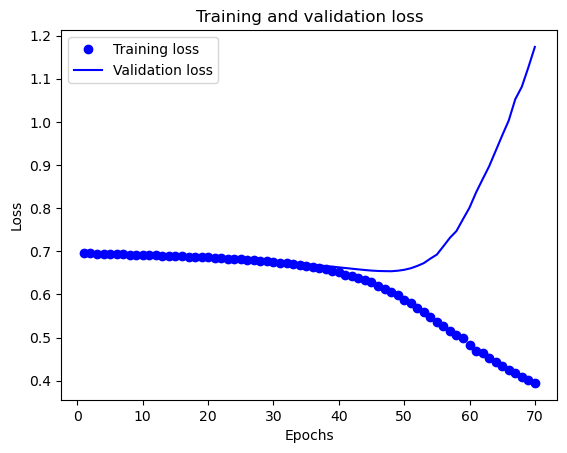

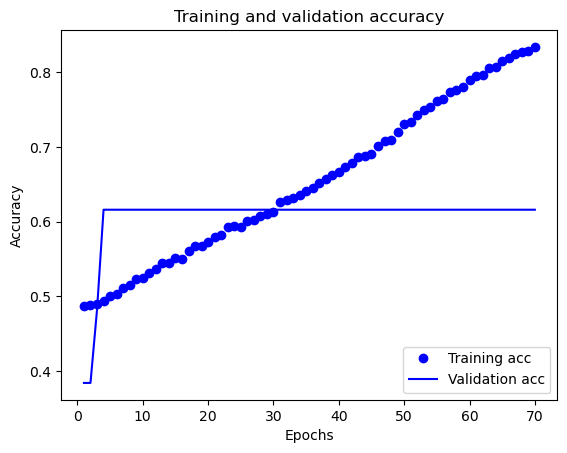


Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1522
           1       0.61      1.00      0.76      2404

    accuracy                           0.61      3926
   macro avg       0.31      0.50      0.38      3926
weighted avg       0.37      0.61      0.47      3926


Confusion Matrix
[[   0 1522]
 [   0 2404]]


c:\Users\George\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\George\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\George\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


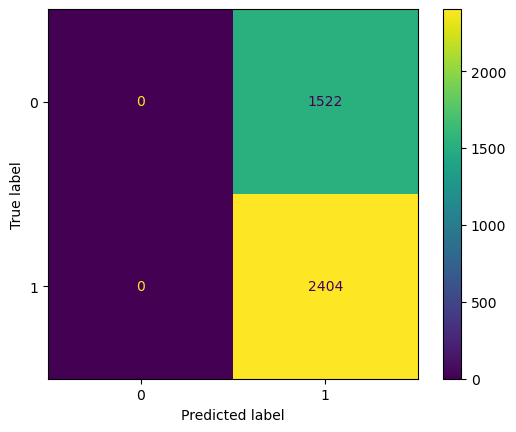

Time taken: 194.4979 seconds


In [ ]:
start_time_1 = time.perf_counter()
with tensorflow.device('/device:GPU:0'):
  # CNN model detection
  # https://keras.io/api/layers/activations/#softmax-function
  detection_model = tensorflow.keras.Sequential([
      tensorflow.keras.layers.Input(shape=(X_rebalance.shape[1],X_rebalance.shape[2])),
      tensorflow.keras.layers.Conv1D(filters=50, kernel_size=3, activation='sigmoid'),
      tensorflow.keras.layers.MaxPooling1D(pool_size=2),
      tensorflow.keras.layers.Dropout(0.3),
      tensorflow.keras.layers.BatchNormalization(),
      tensorflow.keras.layers.LSTM(64),
      tensorflow.keras.layers.Flatten(),
      # 1 layer
      tensorflow.keras.layers.Dense(512, activation='relu'),
      tensorflow.keras.layers.Dropout(0.5),
      # either attack or normal
      tensorflow.keras.layers.Dense(1, activation='sigmoid')
  ])

  detection_model.summary()
  # https://keras.io/api/losses/probabilistic_losses/#probabilistic-losses
  sgd = tensorflow.keras.optimizers.SGD(learning_rate=0.001)
  detection_model.compile(optimizer=sgd,
                loss=tensorflow.keras.losses.BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])

  history = detection_model.fit(X_rebalance, y_rebalance, batch_size=64, epochs=70, validation_data=(X_validation_encode, y_validation_encode))
  test_loss, test_acc = detection_model.evaluate(X_test_encode, y_test_encode)

  # Make predictions
  prediction = detection_model.predict(X_test_encode)
  print(prediction)
  attack_prediction = numpy.where(prediction > 0.5, 1, 0)
  print(attack_prediction)
  print(y_test)

  # Evaluate the model
  print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}\n")
  # https://www.tensorflow.org/tutorials/keras/text_classification for training and validation loss and accuracy
  history_dict = history.history
  # print(history_dict.keys())
  acc = history_dict['accuracy']
  val_acc = history_dict['val_accuracy']
  loss = history_dict['loss']
  val_loss = history_dict['val_loss']

  epochs = range(1, len(acc) + 1)

  # "bo" is for "blue dot"
  plt.plot(epochs, loss, 'bo', label='Training loss')
  # b is for "solid blue line"
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()
  print("\n")

  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(loc='lower right')
  plt.show()

  print("\nClassification Report")
  print(classification_report(y_test, attack_prediction))

  print("\nConfusion Matrix")
  print(confusion_matrix(y_test, attack_prediction))
  ConfusionMatrixDisplay.from_predictions(y_test, attack_prediction)
  plt.show()

end_time1 = time.perf_counter()
print(f"Time taken: {end_time1 - start_time_1:0.4f} seconds")

# Optimizing the model
Instead of looking at random number ranges for learning rates, filters, and hidden units, we have encoded specific values.

The hyper parameters we are attempting to optimize are:

*   Batch Size
*   Activation Functions
*   Learning Rates
*   Filters
*   Hidden Units


The base CNN model we made is ingested into *objective_function*.
  This is where our hyper parameters are being considered.
  It returns the Accuracy of that particular iteration.
**LB** and **UB** is set according to the list given above.



In [ ]:
BATCH_ENCODER = LabelEncoder()
BATCH_ENCODER.fit([32, 64, 128])

#act encoder --> Which activation function should be used?
ACT_ENCODER = LabelEncoder()
ACT_ENCODER.fit(['softmax', 'softplus', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear'])

#Learning Rate encoder
LR_ENCODER = LabelEncoder()
LR_ENCODER.fit([0.0005, 0.001, 0.005, 0.01, 0.05, 0.1])

#Filter encoder
FILTER_ENCODER = LabelEncoder()
FILTER_ENCODER.fit([25, 50, 75])

#Hidden Units encoder
HIDDEN_ENCODER = LabelEncoder()
HIDDEN_ENCODER.fit([400, 512, 640])

def objective_function(params):
  '''RULES:
      Batch Size - 32, 64, 128
      Activation - softmax, softplus, relu, tanh, sigmoid, hard_sigmoid, linear
      Learning Rate - 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1
      Filters - 25, 50, 75
      Hidden Units - 400, 512, 640
      Dense Layers - 5, 8, 10
  '''
  batch_size = BATCH_ENCODER.inverse_transform([int(params[0])])[0]
  activation = ACT_ENCODER.inverse_transform([int(params[1])])[0]
  learning_rate = LR_ENCODER.inverse_transform([int(params[2])])[0]
  filter = FILTER_ENCODER.inverse_transform([int(params[3])])[0]
  hidden_units = HIDDEN_ENCODER.inverse_transform([int(params[4])])[0]

  model = tensorflow.keras.Sequential()
  model.add(tensorflow.keras.layers.Input(shape=(X_rebalance.shape[1], X_rebalance.shape[2]))),
  model.add(tensorflow.keras.layers.Conv1D(filters=filter, kernel_size=3, activation='sigmoid')),
  model.add(tensorflow.keras.layers.MaxPooling1D(pool_size=2)),
  model.add(tensorflow.keras.layers.Dropout(0.3)),
  model.add(tensorflow.keras.layers.BatchNormalization()),
  model.add(tensorflow.keras.layers.LSTM(64)),
  model.add(tensorflow.keras.layers.Flatten()),
  model.add(tensorflow.keras.layers.Dense(int(hidden_units), activation=activation)),
  model.add(tensorflow.keras.layers.Dropout(0.5)),
  model.add(tensorflow.keras.layers.Dense(1, activation='sigmoid'))


  optimizer = tensorflow.keras.optimizers.SGD(learning_rate=learning_rate)
  model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

  history = model.fit(X_rebalance, y_rebalance, batch_size=batch_size, epochs=15, validation_data=(X_validation_encode, y_validation_encode), verbose=0)
  min_validation_accuracy = 1-history.history['val_accuracy'][-1]
  print(f"Accuracy {min_validation_accuracy}")
  return min_validation_accuracy

LB = [0, 0, 0, 0, 0]
UB = [2.99, 6.99, 5.99, 2.99, 2.99]

problem_dict = {
    "obj_func": objective_function,
    "bounds": FloatVar(lb=LB, ub=UB),
    "minmax": "min",
    "verbose": True
}

model = FOX.OriginalFOX(epoch=15, pop_size=20)
g_best = model.solve(problem_dict)
print(f"Solution: {g_best.solution}, Fitness: {g_best.target.fitness}")
print(f"Solution: {model.g_best.solution}, Fitness: {model.g_best.target.fitness}")
model.history.save_global_objectives_chart(filename="FOX-modbus/goc")
model.history.save_local_objectives_chart(filename="FOX-modbus/loc")

model.history.save_global_best_fitness_chart(filename="FOX-modbus/gbfc")
model.history.save_local_best_fitness_chart(filename="FOX-modbus/lbfc")

model.history.save_runtime_chart(filename="FOX-modbus/rtc")

model.history.save_exploration_exploitation_chart(filename="FOX-modbus/eec")

model.history.save_diversity_chart(filename="FOX-modbus/dc")


INFO:mealpy.swarm_based.FOX.OriginalFOX:Solving single objective optimization problem.


Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.6158940494060516
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.6158940494060516
Accuracy 0.38410598039627075
Accuracy 0.6158940494060516
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.6158940494060516
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.6158940494060516
Accuracy 0.6158940494060516
Accuracy 0.6158940494060516
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.6158940494060516
Accuracy 0.6158940494060516
Accuracy 0.6158940494060516
Accuracy 0.6158940494060516
Accuracy 0.38410598039627075
Accuracy 0.6158940494060516
Accuracy 0.38410598039627075
Accuracy 0.384105980396270

INFO:mealpy.swarm_based.FOX.OriginalFOX:>>>Problem: P, Epoch: 1, Current best: 0.38410598039627075, Global best: 0.38410598039627075, Runtime: 2106.19946 seconds


Accuracy 0.6158940494060516
Accuracy 0.6158940494060516
Accuracy 0.38410598039627075
Accuracy 0.6158940494060516
Accuracy 0.38410598039627075
Accuracy 0.6158940494060516
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.6158940494060516
Accuracy 0.38410598039627075
Accuracy 0.6158940494060516
Accuracy 0.6158940494060516
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.6158940494060516
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.6158940494060516
Accuracy 0.38410598039627075


INFO:mealpy.swarm_based.FOX.OriginalFOX:>>>Problem: P, Epoch: 2, Current best: 0.38410598039627075, Global best: 0.38410598039627075, Runtime: 2131.20554 seconds


Accuracy 0.38410598039627075
Accuracy 0.6158940494060516
Accuracy 0.38410598039627075
Accuracy 0.6158940494060516
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.6158940494060516
Accuracy 0.6158940494060516
Accuracy 0.6158940494060516
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.6158940494060516
Accuracy 0.6158940494060516
Accuracy 0.38410598039627075
Accuracy 0.5196128487586975
Accuracy 0.6158940494060516
Accuracy 0.6158940494060516
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075


INFO:mealpy.swarm_based.FOX.OriginalFOX:>>>Problem: P, Epoch: 3, Current best: 0.38410598039627075, Global best: 0.38410598039627075, Runtime: 2070.75109 seconds


Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.6158940494060516
Accuracy 0.6158940494060516
Accuracy 0.38410598039627075
Accuracy 0.6158940494060516
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.6158940494060516
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.6158940494060516
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.5532348453998566
Accuracy 0.6158940494060516
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075


INFO:mealpy.swarm_based.FOX.OriginalFOX:>>>Problem: P, Epoch: 4, Current best: 0.38410598039627075, Global best: 0.38410598039627075, Runtime: 1997.04632 seconds


Accuracy 0.38410598039627075
Accuracy 0.6158940494060516
Accuracy 0.6158940494060516
Accuracy 0.38410598039627075
Accuracy 0.38410598039627075
Accuracy 0.6158940494060516


#Output from the Optimizer

"2025/04/14 09:18:47 AM, INFO, mealpy.swarm_based.FOX.OriginalFOX: Solving single objective optimization problem."
Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.6158940494060516 Accuracy 0.6158940494060516 Accuracy 0.6158940494060516 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.6454406380653381 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.6158940494060516 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.6064696907997131 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075
Accuracy 0.6158940494060516 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.6158940494060516
"2025/04/14 09:55:39 AM, INFO, mealpy.swarm_based.FOX.OriginalFOX: >>>Problem: P, Epoch: 1, Current best: 0.38410598039627075, Global best: 0.38410598039627075, Runtime: 1283.71946 seconds"
Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.6158940494060516 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.6158940494060516 Accuracy 0.38410598039627075 Accuracy 0.6158940494060516 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075
"2025/04/14 10:13:49 AM, INFO, mealpy.swarm_based.FOX.OriginalFOX: >>>Problem: P, Epoch: 2, Current best: 0.38410598039627075, Global best: 0.38410598039627075, Runtime: 1089.65934 seconds"
Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.6158940494060516 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.6158940494060516 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.6158940494060516 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.6158940494060516 Accuracy 0.6158940494060516 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.6158940494060516
"2025/04/14 10:32:02 AM, INFO, mealpy.swarm_based.FOX.OriginalFOX: >>>Problem: P, Epoch: 3, Current best: 0.38410598039627075, Global best: 0.38410598039627075, Runtime: 1092.96946 seconds"
Accuracy 0.6158940494060516 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.6158940494060516 Accuracy 0.6158940494060516 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.6158940494060516 Accuracy 0.38410598039627075 Accuracy 0.6158940494060516 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.6158940494060516
"2025/04/14 10:49:24 AM, INFO, mealpy.swarm_based.FOX.OriginalFOX: >>>Problem: P, Epoch: 4, Current best: 0.38410598039627075, Global best: 0.38410598039627075, Runtime: 1041.92276 seconds"
Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.6158940494060516 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.6158940494060516 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.6158940494060516 Accuracy 0.6158940494060516 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.6158940494060516
"2025/04/14 11:08:34 AM, INFO, mealpy.swarm_based.FOX.OriginalFOX: >>>Problem: P, Epoch: 5, Current best: 0.38410598039627075, Global best: 0.38410598039627075, Runtime: 1149.60196 seconds"
Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.6158940494060516 Accuracy 0.6158940494060516 Accuracy 0.38410598039627075 Accuracy 0.3996434211730957 Accuracy 0.38410598039627075 Accuracy 0.6158940494060516 Accuracy 0.38410598039627075 Accuracy 0.49898117780685425 Accuracy 0.38410598039627075
"2025/04/14 11:26:48 AM, INFO, mealpy.swarm_based.FOX.OriginalFOX: >>>Problem: P, Epoch: 6, Current best: 0.38410598039627075, Global best: 0.38410598039627075, Runtime: 1093.95286 seconds"
Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.6158940494060516 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.6158940494060516 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075
"2025/04/14 11:44:57 AM, INFO, mealpy.swarm_based.FOX.OriginalFOX: >>>Problem: P, Epoch: 7, Current best: 0.38410598039627075, Global best: 0.38410598039627075, Runtime: 1089.71708 seconds"
Accuracy 0.6158940494060516 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.05145186185836792 Accuracy 0.24325013160705566 Accuracy 0.6158940494060516 Accuracy 0.38410598039627075 Accuracy 0.6158940494060516 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075
"2025/04/14 12:03:27 PM, INFO, mealpy.swarm_based.FOX.OriginalFOX: >>>Problem: P, Epoch: 8, Current best: 0.05145186185836792, Global best: 0.05145186185836792, Runtime: 1109.73174 seconds"
Accuracy 0.6158940494060516 Accuracy 0.6158940494060516 Accuracy 0.6158940494060516 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.6158940494060516 Accuracy 0.6158940494060516 Accuracy 0.38410598039627075 Accuracy 0.6158940494060516 Accuracy 0.6026490032672882 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.6158940494060516 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075
"2025/04/14 12:26:13 PM, INFO, mealpy.swarm_based.FOX.OriginalFOX: >>>Problem: P, Epoch: 9, Current best: 0.38410598039627075, Global best: 0.05145186185836792, Runtime: 1366.06660 seconds"
Accuracy 0.6158940494060516 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.6158940494060516 Accuracy 0.6158940494060516 Accuracy 0.6158940494060516 Accuracy 0.38410598039627075 Accuracy 0.6158940494060516 Accuracy 0.6158940494060516 Accuracy 0.38410598039627075 Accuracy 0.6158940494060516 Accuracy 0.06393277645111084 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.35736119747161865 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.6158940494060516 Accuracy 0.38410598039627075
"2025/04/14 12:51:11 PM, INFO, mealpy.swarm_based.FOX.OriginalFOX: >>>Problem: P, Epoch: 10, Current best: 0.06393277645111084, Global best: 0.05145186185836792, Runtime: 1498.19567 seconds"
Accuracy 0.6158940494060516 Accuracy 0.6158940494060516 Accuracy 0.0809984803199768 Accuracy 0.38410598039627075 Accuracy 0.384360671043396 Accuracy 0.38410598039627075 Accuracy 0.6158940494060516 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.6158940494060516 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.7656648010015488 Accuracy 0.6158940494060516 Accuracy 0.6158940494060516 Accuracy 0.6158940494060516 Accuracy 0.6158940494060516 Accuracy 0.6158940494060516 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075
"2025/04/14 01:15:28 PM, INFO, mealpy.swarm_based.FOX.OriginalFOX: >>>Problem: P, Epoch: 11, Current best: 0.0809984803199768, Global best: 0.05145186185836792, Runtime: 1456.79138 seconds"
Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.6158940494060516 Accuracy 0.6158940494060516 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.6158940494060516 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.6158940494060516 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.6158940494060516 Accuracy 0.6158940494060516 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.6158940494060516
"2025/04/14 01:40:23 PM, INFO, mealpy.swarm_based.FOX.OriginalFOX: >>>Problem: P, Epoch: 12, Current best: 0.38410598039627075, Global best: 0.05145186185836792, Runtime: 1494.46940 seconds"
Accuracy 0.6158940494060516 Accuracy 0.6158940494060516 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.6158940494060516 Accuracy 0.6158940494060516 Accuracy 0.6158940494060516 Accuracy 0.38410598039627075 Accuracy 0.6158940494060516 Accuracy 0.38410598039627075 Accuracy 0.6158940494060516 Accuracy 0.38410598039627075 Accuracy 0.6158940494060516 Accuracy 0.38410598039627075 Accuracy 0.20071321725845337 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075
"2025/04/14 02:05:03 PM, INFO, mealpy.swarm_based.FOX.OriginalFOX: >>>Problem: P, Epoch: 13, Current best: 0.20071321725845337, Global best: 0.05145186185836792, Runtime: 1480.75111 seconds"
Accuracy 0.38410598039627075 Accuracy 0.6158940494060516 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.6158940494060516 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.6158940494060516 Accuracy 0.38410598039627075 Accuracy 0.6158940494060516 Accuracy 0.38410598039627075 Accuracy 0.6158940494060516 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.6158940494060516 Accuracy 0.38410598039627075 Accuracy 0.65639328956604 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.6158940494060516
"2025/04/14 02:29:05 PM, INFO, mealpy.swarm_based.FOX.OriginalFOX: >>>Problem: P, Epoch: 14, Current best: 0.38410598039627075, Global best: 0.05145186185836792, Runtime: 1441.64882 seconds"
Accuracy 0.6158940494060516 Accuracy 0.6158940494060516 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.4572083353996277 Accuracy 0.38410598039627075 Accuracy 0.6158940494060516 Accuracy 0.6158940494060516 Accuracy 0.38410598039627075 Accuracy 0.6158940494060516 Accuracy 0.38410598039627075 Accuracy 0.6158940494060516 Accuracy 0.6158940494060516 Accuracy 0.6158940494060516 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.38410598039627075 Accuracy 0.6158940494060516 Accuracy 0.38410598039627075 Accuracy 0.6158940494060516
"2025/04/14 02:53:26 PM, INFO, mealpy.swarm_based.FOX.OriginalFOX: >>>Problem: P, Epoch: 15, Current best: 0.38410598039627075, Global best: 0.05145186185836792, Runtime: 1460.58057 seconds"

"Accuracy 0.38410598039627075 Solution: [0.3342297 0.61263055 1.01915999 0.26779645 0.46019358], Fitness: 0.05145186185836792 Solution: [0.3342297 0.61263055 1.01915999 0.26779645 0.46019358], Fitness: 0.05145186185836792"

# Solution

Solution: [0.3342297 0.61263055 1.01915999 0.26779645 0.46019358], Fitness: 0.05145186185836792

Batch Size - **32**, 64, 128

Activation - **softmax**, softplus, relu, tanh, sigmoid, hard_sigmoid, linear

Learning Rate - 0.0005, **0.001**, 0.005, 0.01, 0.05, 0.1

Filters - **25**, 50, 75

Hidden Units - **400**, 512, 640

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 3, 25)          │           100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1, 25)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 25)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1, 25)          │           100 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        23,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 400)            │        26,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           401 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,641 (193.91 KB)

 Trainable params: 49,591 (193.71 KB)

 Non-trainable params: 50 (200.00 B)

Epoch 1/70
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.4949 - loss: 0.6932 - val_accuracy: 0.3841 - val_loss: 0.6935
Epoch 2/70
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.4893 - loss: 0.6932 - val_accuracy: 0.3841 - val_loss: 0.6935
Epoch 3/70
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.4994 - loss: 0.6932 - val_accuracy: 0.3841 - val_loss: 0.6934
Epoch 4/70
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5009 - loss: 0.6932 - val_accuracy: 0.3841 - val_loss: 0.6933
Epoch 5/70
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.4985 - loss: 0.6932 - val_accuracy: 0.3841 - val_loss: 0.6932
Epoch 6/70
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.4910 - loss: 0.6932 - val_accuracy: 0.6159 - val_loss: 0.6931
Epoch 7/70
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.4950 - loss: 0.6932 - val_accuracy: 0.6159 - val_loss: 0.6931
Epoch 8/70
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.4939 - loss: 0.6932 - 

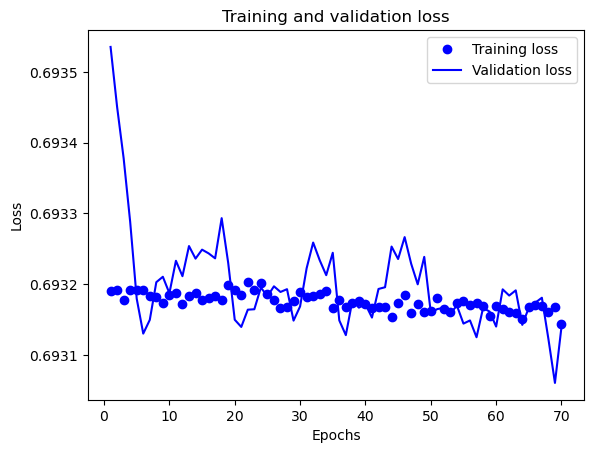

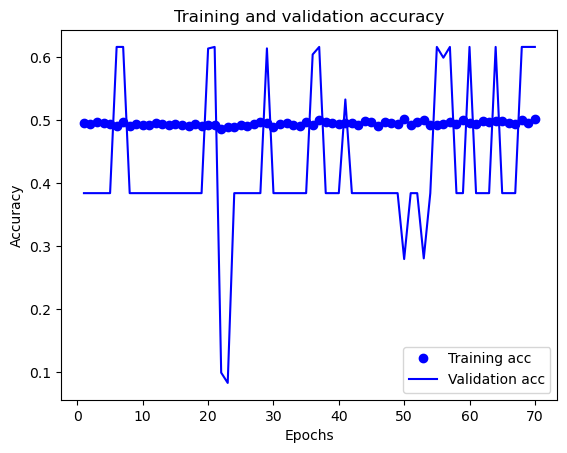


Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1522
           1       0.61      1.00      0.76      2404

    accuracy                           0.61      3926
   macro avg       0.31      0.50      0.38      3926
weighted avg       0.37      0.61      0.47      3926


Confusion Matrix
[[   0 1522]
 [   0 2404]]


c:\Users\George\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\George\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\George\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


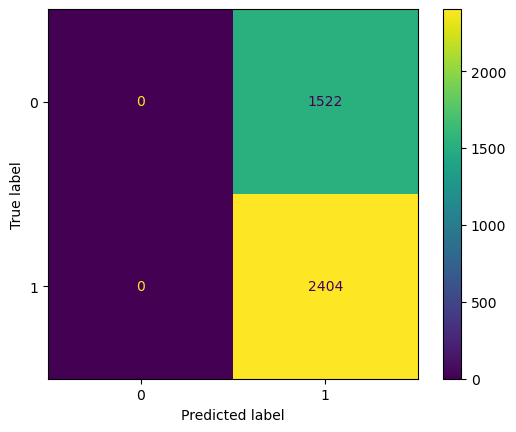

Time taken: 359.1857 seconds


In [ ]:
start_time_2 = time.perf_counter()
with tensorflow.device('/device:GPU:0'):
  # CNN model detection
  # https://keras.io/api/layers/activations/#softmax-function
  detection_model = tensorflow.keras.Sequential([
      tensorflow.keras.layers.Input(shape=(X_rebalance.shape[1],X_rebalance.shape[2])),
      tensorflow.keras.layers.Conv1D(filters=25, kernel_size=3, activation='linear'),
      tensorflow.keras.layers.MaxPooling1D(pool_size=2),
      tensorflow.keras.layers.Dropout(0.3),
      tensorflow.keras.layers.BatchNormalization(),
      tensorflow.keras.layers.LSTM(64),
      tensorflow.keras.layers.Flatten(),
      # 1 layer
      tensorflow.keras.layers.Dense(400, activation='softmax'),
      tensorflow.keras.layers.Dropout(0.5),
      # either attack or normal
      tensorflow.keras.layers.Dense(1, activation='sigmoid')
  ])

  detection_model.summary()
  # https://keras.io/api/losses/probabilistic_losses/#probabilistic-losses
  sgd = tensorflow.keras.optimizers.SGD(learning_rate=0.001)
  detection_model.compile(optimizer=sgd,
                loss=tensorflow.keras.losses.BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])

  history = detection_model.fit(X_rebalance, y_rebalance, batch_size=32, epochs=70, validation_data=(X_validation_encode, y_validation_encode))
  test_loss, test_acc = detection_model.evaluate(X_test_encode, y_test_encode)

  # Make predictions
  prediction = detection_model.predict(X_test_encode)
  print(prediction)
  attack_prediction = numpy.where(prediction > 0.5, 1, 0)
  print(attack_prediction)
  print(y_test)

  # Evaluate the model
  print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}\n")
  # https://www.tensorflow.org/tutorials/keras/text_classification for training and validation loss and accuracy
  history_dict = history.history
  # print(history_dict.keys())
  acc = history_dict['accuracy']
  val_acc = history_dict['val_accuracy']
  loss = history_dict['loss']
  val_loss = history_dict['val_loss']

  epochs = range(1, len(acc) + 1)

  # "bo" is for "blue dot"
  plt.plot(epochs, loss, 'bo', label='Training loss')
  # b is for "solid blue line"
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()
  print("\n")

  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(loc='lower right')
  plt.show()

  print("\nClassification Report")
  print(classification_report(y_test, attack_prediction))

  print("\nConfusion Matrix")
  print(confusion_matrix(y_test, attack_prediction))
  ConfusionMatrixDisplay.from_predictions(y_test, attack_prediction)
  plt.show()

end_time2 = time.perf_counter()
print(f"Time taken: {end_time2 - start_time_2:0.4f} seconds")